In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import geo 


Read the extracted catalog from Flagship SC8 simulation


In [2]:
T = Table.read("/feynman/work/dap/lceg/rp269101/stuff/eBOSS_LRG_flagship.fits")
ra = T['ra']
dec = T['dec']
z_obs = T['z']
w = T['w']


construct random catalog and extract nz

In [3]:
NSIDE = 512

"""Z-range within witch the sample was constructed"""
Xmin = 0.5
Xmax = 1.1
footprint = geo.survey_geometry(NSIDE,RA=T['ra'],DEC=T['dec'])
footprint.set_target_nz(Z=z_obs,W=w,xmin=Xmin,xmax=Xmax)
ra_rand,dec_rand,z_rand,w_rand = footprint.create_random(size_random=int(len(ra)*15))
center,edges,dn,nz = footprint.compute_nz()
low_edge = edges[0:len(edges)-1]
high_edge = edges[1:len(edges)]



Check the randoms 

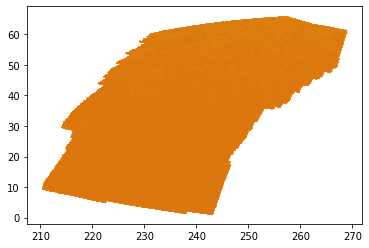

In [4]:
plt.scatter(ra,dec,s=0.0001)
plt.scatter(ra_rand,dec_rand,s=0.0001)

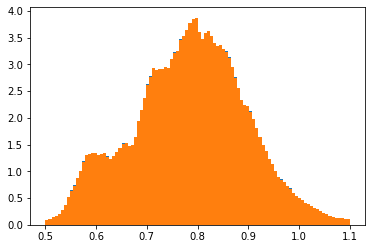

In [5]:
_=plt.hist(z_obs,bins=100,density=True)
_=plt.hist(z_rand,bins=100,density=True)

Then we can save the random to a fit table and compute $w_g+$. 

To save this to table: \
T_rand = Table([ra_rand,dec_rand,z_rand,np.ones(len(ra_rand))],names=('ra','dec','z','w'))
T_rand.write('eBOSS_LRGr_flagship.fits',format='fits',overwrite=True)


Now i used the python script corr2.py to compute  $w_g+$, see pipeline_wgp.py for an example. \

Now lets read the measurements

In [6]:
r,meanr,meanglogr,xi,err = np.loadtxt("/feynman/home/dap/lceg/rp269101/code/euclid/wgp_LRG_flagship_jack_final_v7.dat").T
cov = np.loadtxt("/feynman/home/dap/lceg/rp269101/code/euclid/cov_wgp_LRG_flagship_jack_final_v7.dat")


We are now going to convert the .ascii format into a fits format that Cosmosis understand, see https://github.com/joezuntz/2point and the corresponding example.


To the primary HDU is add a header named COMMENT, to explain how the measurements were performed. 
Here, this is minimal example with a single observation, $w_g+$, and a single n(z) distribution as we are measuring auto-correlation only.



In [7]:
hdu = fits.PrimaryHDU()
hdu.header['COMMENT']='wg+ is calculated by integration over radial bins of size 10Mpc/h \
up to 100 Mpc/h. The covariance is estimated from jackknife. Cosmology used, h=1, Om0=0.319'
"""covariance saved as an Image HDU"""

hdu2 = fits.ImageHDU(cov,name='COVMAT')

"""data saved as a Table HDU. Note that we specify the name of the quantity we measure,
i.e wg+. We also need to specify the quantities involved in the correlation, see the cosmosis
folder"""

#hdu2.header
c1 = fits.Column(name='VALUE', array=xi, format='D')
c2 = fits.Column(name='ANG', array=meanr, format='D',unit='rad')
c3 = fits.Column(name='BIN1', array=np.ones(len(xi)), format='K')
c4 = fits.Column(name='BIN2', array=np.ones(len(xi)), format='K')
arrayr= np.logspace(np.log10(1e-1),np.log10(100),22)
c5 = fits.Column(name='ANGBIN', array=np.arange(1,len(arrayr),1), format='K')

table_hdu = fits.BinTableHDU.from_columns([c3,c4,c5,c1,c2],name="wgp")
T=1
table_hdu.header['2PTDATA']=T
table_hdu.header['N_ANG']=21

table_hdu.header['QUANT1']='GPS'
table_hdu.header['QUANT2']='G+S'
#table_hdu.header['TUNIT5']='RAD'

table_hdu.header['KERNEL_1']='NZ_SOURCE'
table_hdu.header['KERNEL_2']='NZ_SOURCE'
table_hdu.header['N_ZBIN_1']=1
table_hdu.header['N_ZBIN_2']=1
table_hdu.header['WINDOWS']='SAMPLE'
hdu2.header['NAME_0']  = 'WGP'
hdu2.header['STRT_0']  = 0

"""n(z) saved as an other Table HDU"""
c1 = fits.Column(name='Z_LOW', array=low_edge, format='D')
c2 = fits.Column(name='Z_HIGH', array=high_edge, format='D')
c3 = fits.Column(name='Z_MID', array=center, format='D')
c4 = fits.Column(name='BIN1', array=np.ones(len(center)), format='D')

table_hdu2= fits.BinTableHDU.from_columns([c1,c2,c3,c4],name="NZ_SOURCE")
table_hdu2.header['NZDATA']=T

hdul = fits.HDUList([hdu,hdu2,table_hdu,table_hdu2])
hdul.writeto('flagship_wgp_LRG.fits',overwrite=True)

In [8]:
hdu.header['COMMENT']

wg+ is calculated by integration over radial bins of size 10Mpc/h up to
100 Mpc/h. The covariance is estimated from jackknife. Cosmology used, h
=1, Om0=0.319

In [9]:
hdul[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =                   21 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'BIN1    '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'BIN2    '                                                            
TFORM2  = 'K       '                                                            
TTYPE3  = 'ANGBIN  '        

In [10]:
hdul[3].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                  120 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'Z_LOW   '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'Z_HIGH  '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z_MID   '        

In [11]:
hdul[3].data

FITS_rec([(0.5  , 0.505, 0.5025, 1.), (0.505, 0.51 , 0.5075, 1.),
          (0.51 , 0.515, 0.5125, 1.), (0.515, 0.52 , 0.5175, 1.),
          (0.52 , 0.525, 0.5225, 1.), (0.525, 0.53 , 0.5275, 1.),
          (0.53 , 0.535, 0.5325, 1.), (0.535, 0.54 , 0.5375, 1.),
          (0.54 , 0.545, 0.5425, 1.), (0.545, 0.55 , 0.5475, 1.),
          (0.55 , 0.555, 0.5525, 1.), (0.555, 0.56 , 0.5575, 1.),
          (0.56 , 0.565, 0.5625, 1.), (0.565, 0.57 , 0.5675, 1.),
          (0.57 , 0.575, 0.5725, 1.), (0.575, 0.58 , 0.5775, 1.),
          (0.58 , 0.585, 0.5825, 1.), (0.585, 0.59 , 0.5875, 1.),
          (0.59 , 0.595, 0.5925, 1.), (0.595, 0.6  , 0.5975, 1.),
          (0.6  , 0.605, 0.6025, 1.), (0.605, 0.61 , 0.6075, 1.),
          (0.61 , 0.615, 0.6125, 1.), (0.615, 0.62 , 0.6175, 1.),
          (0.62 , 0.625, 0.6225, 1.), (0.625, 0.63 , 0.6275, 1.),
          (0.63 , 0.635, 0.6325, 1.), (0.635, 0.64 , 0.6375, 1.),
          (0.64 , 0.645, 0.6425, 1.), (0.645, 0.65 , 0.6475, 1.),
          